<a href="https://colab.research.google.com/github/tiagoandremv/MachineLearning/blob/main/FaceUNMASKER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação de bibliotecas

In [12]:
# IMPORTAÇÃO DE BIBLIOTECAS NECESSÁRIAS
import os
import cv2
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, mean_squared_error, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers    import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models    import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses    import SparseCategoricalCrossentropy, CategoricalCrossentropy, binary_crossentropy

from random import shuffle
from tqdm   import tqdm # permite verificar o progresso do carregamento


class PrepareData:

  def __init__(self):
    path = '/content/drive/My Drive/Colab Notebooks/tdx_project/dataset-proj/'
    self.train_path = path + 'train/'  
    self.validation_path = path + 'validation/' 

  def label_img(self, _path):
    word_label = _path.split('/')[-2]
    return [1] if word_label == 'fake' else [0]
    # if word_label == 'fake':
    #   return [1]
    # elif word_label == 'real':
    #   return [0,1]

  def scale_image(self, img, scale_percent = 50):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    scale = (width, height)
    img = cv2.resize(img, scale)
    return img

  def load_prepare_data (self, _type):
    dataset = []
    _path = self.train_path if _type == 'train' else self.validation_path 
    
    for folder in os.listdir(_path): #['fake', 'real']
      path_folder = os.path.join(_path, folder)
      
      for filename in tqdm(os.listdir(path_folder)):
        path = os.path.join(path_folder, filename)
        label = self.label_img(path) # [0,1] para real , [1,0] para fake

        img = cv2.imread(path)
        img = self.scale_image(img)
        img = img.astype("float64") / 255.0
        #original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        
        dataset.append([np.array(img), np.array(label)])
    
    shuffle(dataset)
    return dataset    


def plot_all_images(images):
  for i in range(len(images)):
    plt.subplot(1,len(images),i+1) 
    plt.imshow(images[i])
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
  plt.show()

def plot_image(img):
  plot = plt.figure()
#  plot = plot.add_subplot(4, 5, num + 1)
  plot.imshow(img)
  plot.show()

#Carregamento de Imagens

In [2]:
pData = PrepareData()
train_data = pData.load_prepare_data(_type = 'train')
validation_data = pData.load_prepare_data(_type = 'validation')

NameError: ignored

In [ ]:
print("train_data Shape: ", np.asarray(train_data).shape)
print("validation_data Shape: ", np.asarray(validation_data).shape)

num, data = train_data[0]

inputs_shape = num.shape
print("Inputs Shape: ", inputs_shape)

#Definição de features

In [ ]:
# X-Features & Y-Labels
train_images = np.array([i[0] for i in train_data])
train_labels = np.array([i[1] for i in train_data]).astype('float64')

validation_images = np.array([i[0] for i in validation_data])
validation_labels = np.array([i[1] for i in validation_data]).astype('float64')

print("Images, shape and type: ", train_images.shape, train_images.dtype)
print("Labels, shape and type: ", train_labels.shape, train_labels.dtype)

# Definição do MODEL

In [1]:
early_callback = EarlyStopping(monitor = 'loss', patience = 2)

model = Sequential()
model.add(Conv2D(16, 3, activation='relu', padding='same', input_shape=inputs_shape))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))


model.compile(optimizer='adam', 
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

NameError: ignored

In [6]:
history = model.fit(train_images, 
                    train_labels, 
                    epochs = 30, 
                    validation_data = (validation_images, validation_labels), 
                    #callbacks = [early_callback] 
                    )

Epoch 1/30
44/44 [==============================] - 4s 81ms/step - loss: 0.9482 - accuracy: 0.5150 - val_loss: 0.6696 - val_accuracy: 0.6000
Epoch 2/30
44/44 [==============================] - 3s 62ms/step - loss: 0.6475 - accuracy: 0.6157 - val_loss: 0.6367 - val_accuracy: 0.6300
Epoch 3/30
44/44 [==============================] - 3s 61ms/step - loss: 0.4859 - accuracy: 0.7650 - val_loss: 0.5856 - val_accuracy: 0.6900
Epoch 4/30
44/44 [==============================] - 3s 62ms/step - loss: 0.3650 - accuracy: 0.8336 - val_loss: 0.5488 - val_accuracy: 0.7217
Epoch 5/30
44/44 [==============================] - 3s 62ms/step - loss: 0.2644 - accuracy: 0.8871 - val_loss: 0.6257 - val_accuracy: 0.7600
Epoch 6/30
44/44 [==============================] - 3s 62ms/step - loss: 0.1640 - accuracy: 0.9364 - val_loss: 0.8041 - val_accuracy: 0.7183
Epoch 7/30
44/44 [==============================] - 3s 63ms/step - loss: 0.1027 - accuracy: 0.9679 - val_loss: 0.9364 - val_accuracy: 0.7450
Epoch 8/30
44

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 64)      8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 128)       0

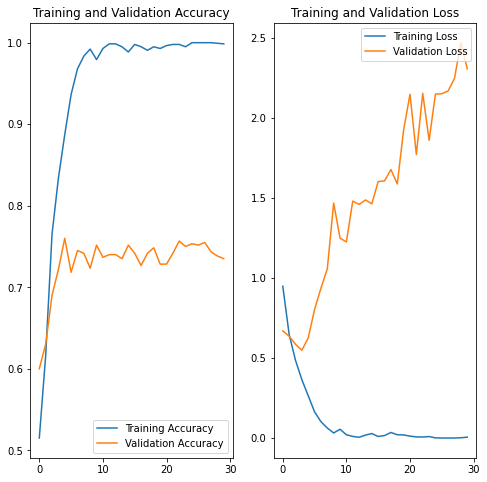

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# APRESENTAÇÃO DE RESULTADOS

#print("Confusion Matrix\n", confusion_matrix(y_train, train_predictions))
#print("Accuracy: %.2f %%" % (accuracy_score(y_train, train_predictions) * 100))